# Proyek Klasifikasi Gambar: OCR Alphabets Classification
- **Nama:** Muhammad Ricky Rizaldi
- **Email:** mrickyrizaldi@gmail.com
- **ID Dicoding:** mrickyr

# Import Semua Packages/Library yang Digunakan

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.18.0 -q

In [3]:
# Library untuk operasi sistem, manipulasi file, dan zip
import os
import shutil
import zipfile
import random

# Library untuk manipulasi data dan analisis
import numpy as np
import pandas as pd

# Library untuk pengolahan gambar
import cv2
from PIL import Image
from skimage.transform import rotate, AffineTransform, warp, resize
import skimage.util as sk_util
from skimage import img_as_ubyte

# Library untuk plotting dan visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk evaluasi model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Library untuk TensorFlow dan Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Library untuk manipulasi path
import pathlib

In [4]:
print(tf.__version__)

2.18.0


# Data Preparation

## Data Loading

In [5]:
# Path ke file ZIP
zip_path = "/content/drive/MyDrive/data/OCR_datasets.zip"
extract_path = "OCR_unzip"

# Ekstrak file ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset berhasil diekstrak")

# Pengecekan hasil unzip
classes = sorted(os.listdir(extract_path))
print(f"Jumlah kelas: {len(classes)}")

Dataset berhasil diekstrak
Jumlah kelas: 62


In [6]:
# Memfilter data yang akan digunakan dari dataset
# Gabungkan data huruf lowercase dan uppercase
merged_class_path = "OCR_unzip"

# Buat folder A-Z baru
for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    new_folder_path = os.path.join(merged_class_path, letter)
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

# Loop melalui folder lama dan pindahkan file
for folder in os.listdir(merged_class_path):
    old_path = os.path.join(merged_class_path, folder)

    # Cek apakah folder ini menggunakan format X_U atau x_L
    if os.path.isdir(old_path) and (folder.endswith("_U") or folder.endswith("_L")):
        letter = folder[0].upper()  # Konversi huruf pertama ke uppercase
        new_folder = os.path.join(merged_class_path, letter)

        # Pastikan folder tujuan sudah ada
        if not os.path.exists(new_folder):
            os.makedirs(new_folder)

        # Pindahkan semua file ke folder baru
        for file in os.listdir(old_path):
            source_path = os.path.join(old_path, file)
            destination_path = os.path.join(new_folder, file)
            shutil.move(source_path, destination_path)

        # Hapus folder lama setelah dipindahkan
        os.rmdir(old_path)

# Hapus folder dengan nama Angka
for i in range(10):  # Loop untuk angka 0-9
    digit_folder = os.path.join(merged_class_path, str(i))
    if os.path.exists(digit_folder) and os.path.isdir(digit_folder):
        shutil.rmtree(digit_folder)  # Hapus folder

# Cek hasil pengelompokan
classes_new = sorted(os.listdir(merged_class_path))
print(f"Jumlah kelas setelah penggabungan: {len(classes_new)}")
print(f"Contoh kelas: {classes_new}")

Jumlah kelas setelah penggabungan: 26
Contoh kelas: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [7]:
# Mengambil gambar untuk inference
# Buat folder unseen_images jika belum ada
unseen_images_dir = "unseen_images"
if not os.path.exists(unseen_images_dir):
    os.makedirs(unseen_images_dir)

# Loop melalui setiap kelas
for class_name in classes_new:
    class_path = os.path.join(merged_class_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)
        if images:
            # Ambil satu gambar secara acak dari kelas tersebut
            selected_image = random.choice(images)
            source_image_path = os.path.join(class_path, selected_image)
            destination_image_path = os.path.join(unseen_images_dir, selected_image)

            # Pindahkan gambar ke folder unseen_images
            shutil.move(source_image_path, destination_image_path)

In [8]:
def check_image_resolution(dataset_path, num_samples=5):
    sample_class = random.choice(os.listdir(dataset_path))
    sample_class_path = os.path.join(dataset_path, sample_class)
    sample_images = random.sample(os.listdir(sample_class_path), num_samples)
    for img_name in sample_images:
        img_path = os.path.join(sample_class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is not None:
            print(f"{sample_class}/{img_name} -> {img.shape}")
        else:
            print(f"Failed to load {sample_class}/{img_name}")

# Cek resolution size dari 5 gambar secara acak dari dataset
check_image_resolution(extract_path, num_samples=5)

X/X_U_2879.png -> (72, 62)
X/X_L_2627.png -> (66, 118)
X/X_U_1362.png -> (76, 69)
X/X_U_1544.png -> (71, 90)
X/X_L_1293.png -> (80, 114)


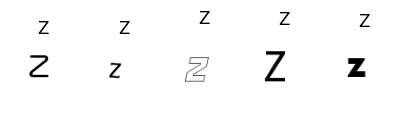

In [10]:
def show_random_images(dataset_path, num_images=5):
    classes = os.listdir(dataset_path)
    random_class = random.choice(classes)  # Memilih kelas random
    class_path = os.path.join(dataset_path, random_class)
    image_files = os.listdir(class_path)
    random_images = random.sample(image_files, min(num_images, len(image_files)))

    fig, axes = plt.subplots(1, len(random_images), figsize=(5, 5))
    for i, img_name in enumerate(random_images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(random_class)

    plt.show()

# Menampilkan gambar
show_random_images("OCR_unzip")

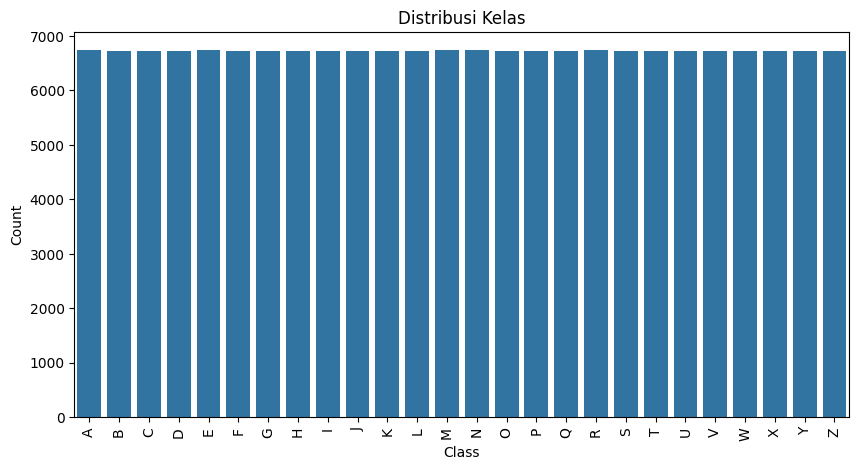

In [11]:
def plot_class_distribution(dataset_path):
    class_counts = {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in os.listdir(dataset_path)}
    df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
    df.sort_values(by=['Class'], inplace=True)
    class_order = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    plt.figure(figsize=(10, 5))
    sns.barplot(x="Class", y="Count", data=df, order=class_order)
    plt.xticks(rotation=90)
    plt.title("Distribusi Kelas")
    plt.show()

# Distribusi kelas di dataset
plot_class_distribution("OCR_unzip")

## Data Preprocessing

### Resize Resolution

In [12]:
def resize_dataset(input_folder, output_folder, target_size=(64, 64), padding=10):
    """Resize dataset dengan menggunakan bounding box."""
    os.makedirs(output_folder, exist_ok=True)

    for class_name in os.listdir(input_folder):
        input_class_path = os.path.join(input_folder, class_name)
        output_class_path = os.path.join(output_folder, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for img_name in os.listdir(input_class_path):
            img_path = os.path.join(input_class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            if img is None:
                continue  # Skip jika tidak bisa dibaca

            _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
                x = max(0, x - padding)
                y = max(0, y - padding)
                w = min(img.shape[1] - x, w + 2 * padding)
                h = min(img.shape[0] - y, h + 2 * padding)
                cropped = img[y:y+h, x:x+w]
            else:
                cropped = img

            # Resize dengan mempertahankan rasio
            scale = min(target_size[0] / h, target_size[1] / w)
            new_w, new_h = int(w * scale), int(h * scale)
            resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_AREA)

            # Membuat canvas putih dengan ukuran target_size dan menempatkan gambar di tengah
            final_img = np.ones(target_size, dtype=np.uint8) * 255
            start_x = (target_size[1] - new_w) // 2
            start_y = (target_size[0] - new_h) // 2
            final_img[start_y:start_y+new_h, start_x:start_x+new_w] = resized
            cv2.imwrite(os.path.join(output_class_path, img_name), final_img)

resized_path = "OCR_resized"
resize_dataset(extract_path, resized_path)
print("Resize selesai")

Resize selesai


In [13]:
# Cek resolution size dari 10 gambar secara acak dari hasil resize
check_image_resolution(resized_path, num_samples=10)

I/I_L_2511.png -> (64, 64)
I/I_L_1230.png -> (64, 64)
I/I_L_1155.png -> (64, 64)
I/I_L_1978.png -> (64, 64)
I/I_U_3200.png -> (64, 64)
I/I_U_2292.png -> (64, 64)
I/I_L_3113.png -> (64, 64)
I/I_U_2080.png -> (64, 64)
I/I_U_2370.png -> (64, 64)
I/I_L_139.png -> (64, 64)


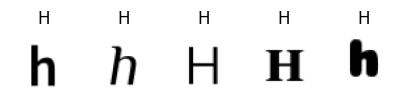

In [14]:
# Menampilkan gambar
show_random_images(resized_path)

### Data Splitting

In [15]:
# Path folder dataset
dataset_path = "OCR_datasets"
resized_path = "OCR_resized"

# Buat folder output
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_path, split), exist_ok=True)

# Loop untuk setiap kelas
for class_name in classes_new:
    class_path = os.path.join(resized_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # List semua file dalam kelas
    files = np.array(os.listdir(class_path))

    # Splitting dataset
    train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Pindahkan file ke folder yang sesuai
    for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        split_class_path = os.path.join(dataset_path, split, class_name)
        os.makedirs(split_class_path, exist_ok=True)
        for file in split_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(split_class_path, file))

In [16]:
def count_files_in_splits(base_path):
    splits = ["train", "val", "test"]
    for split in splits:
        split_path = os.path.join(base_path, split)
        total_files = sum([len(files) for _, _, files in os.walk(split_path)])
        print(f"Total {split}: {total_files} files")

# Cek jumlah data per split
count_files_in_splits("OCR_datasets")

Total train: 122493 files
Total val: 26245 files
Total test: 26265 files


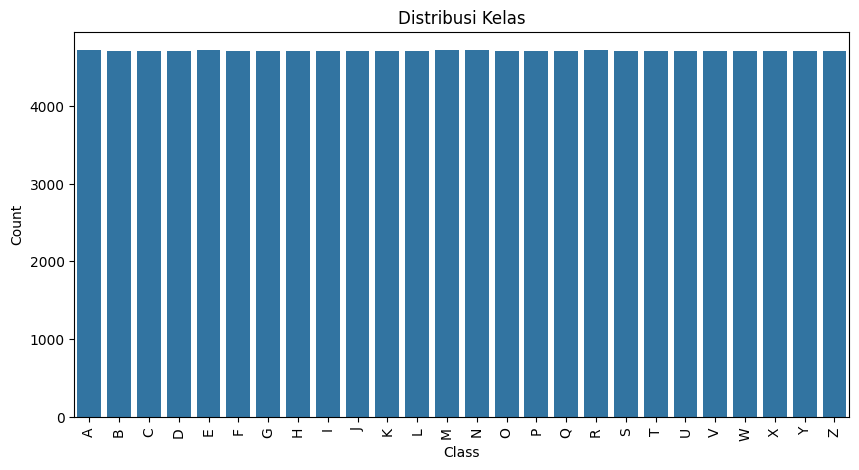

In [17]:
# Distribusi kelas di dataset
plot_class_distribution("/content/OCR_datasets/train")

### Augmentasi Data

In [18]:
# Tambahkan data augmentasi untuk generalisasi yang lebih baik
def rotate_image(img):
    """Rotasi gambar dengan sudut acak antara -10 hingga 10 derajat"""
    angle = random.randint(-10, 10)
    rotated_img = rotate(img, angle, mode="edge", preserve_range=True)
    return rotated_img.astype(np.uint8)

def shear_image(img):
    """Shear gambar dengan faktor acak antara -0.15 hingga 0.15"""
    shear_val = random.uniform(-0.15, 0.15)
    transform = AffineTransform(shear=shear_val)
    sheared_img = warp(img, transform, mode="reflect", preserve_range=True)
    return sheared_img.astype(np.uint8)

def blur_image(img, probability=0.2):
    """Blur gambar menggunakan Gaussian Blur dengan kernel 3 atau 5 dengan probabilitas 20%"""
    if random.random() < probability:
        kernel_size = random.choice([3, 5])
        img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    return img

def translate_image(img, max_shift=0.05):
    """Geser gambar secara horizontal atau vertikal dalam rentang max_shift"""
    h, w = img.shape
    max_dx = int(max_shift * w)
    max_dy = int(max_shift * h)

    dx = random.randint(-max_dx, max_dx)
    dy = random.randint(-max_dy, max_dy)

    transform = AffineTransform(translation=(dx, dy))
    translated_img = warp(img, transform, mode="constant", cval=255, preserve_range=True)
    return translated_img.astype(np.uint8)

def adjust_brightness_contrast(img):
    """Atur kontras dan kecerahan gambar acak"""
    alpha = random.uniform(0.8, 1.2)  # Kontras
    beta = random.randint(-10, 10)    # Kecerahan
    adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    return adjusted

def apply_augmentation(img):
    """Terapkan 2-3 augmentasi sekaligus pada gambar"""
    augmentations_list = list(augmentations.values())
    num_augmentations = random.randint(2, 3)
    for _ in range(num_augmentations):
        augmentation_func = random.choice(augmentations_list)
        img = augmentation_func(img)
    return img_as_ubyte(img)

In [ ]:
# Peta fungsi augmentasi
augmentations = {
    "rotate": rotate_image,
    "shear": shear_image,
    "blur": blur_image,
    "translate": translate_image,
    "adjust brightness & contrast": adjust_brightness_contrast
}

# Folder dataset asli dan output augmentasi
train_dir = "/content/OCR_datasets/train"
augmented_dir = "/content/OCR_datasets/train_aug"

# Loop kelas
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    augmented_class_path = os.path.join(augmented_dir, class_name)

    if os.path.isdir(class_path):
        os.makedirs(augmented_class_path, exist_ok=True)
        image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path)]

        # Lakukan Augmentasi sebanyak 20% dari total kelas
        augment_per_class = int(0.2 * len(image_paths))

        i = 0
        while i < augment_per_class:
            image_path = random.choice(image_paths)
            original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Pastikan grayscale

            if original_image is None:
                print(f"Skipping {image_path}, cannot read image.")
                continue

            try:
                transformed_image = apply_augmentation(original_image)
                new_image_path = os.path.join(augmented_class_path, f"augmented_{i}.png")
                cv2.imwrite(new_image_path, transformed_image)
                i += 1
            except Exception as e:
                print(f"Error processing {image_path}: {e}, skipping...")

print("Augmentasi selesai dan disimpan di folder 'train_aug'")

Augmentasi selesai dan disimpan di folder 'train_aug'


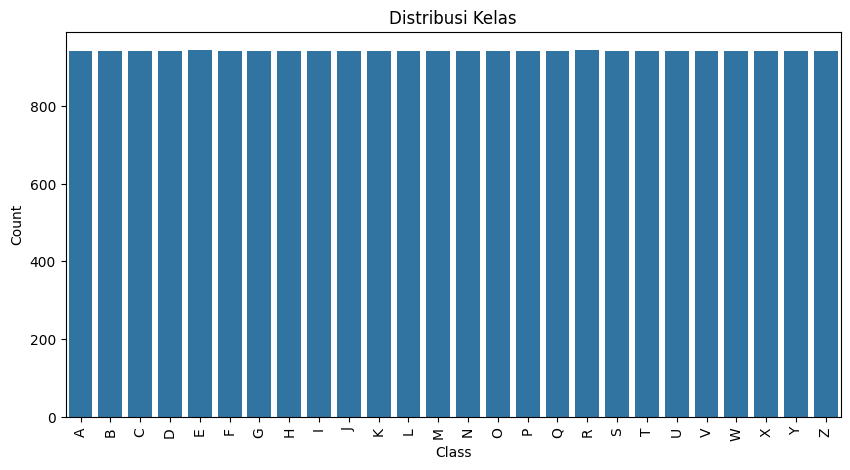

In [ ]:
# Distribusi kelas hasil train_aug
plot_class_distribution("/content/OCR_datasets/train_aug")

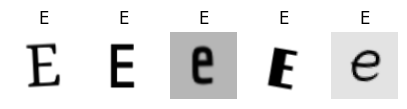

I/augmented_401.png -> (64, 64)
I/augmented_495.png -> (64, 64)
I/augmented_291.png -> (64, 64)
I/augmented_14.png -> (64, 64)
I/augmented_489.png -> (64, 64)


In [ ]:
# Menampilkan gambar dari folder train_aug
show_random_images("OCR_datasets/train_aug")
# Cek resolution size dari 5 gambar secara acak dari hasil train_aug
check_image_resolution(augmented_dir, num_samples=5)

In [ ]:
# Direktori gabungan dataset asli dan hasil augmentasi
merged_dir = "/content/OCR_datasets/train_all"

# Loop melalui kelas yang ada di train
for class_name in os.listdir(train_dir):
    class_train_path = os.path.join(train_dir, class_name)
    class_augmented_path = os.path.join(augmented_dir, class_name)
    class_merged_path = os.path.join(merged_dir, class_name)

    if os.path.isdir(class_train_path):
        os.makedirs(class_merged_path, exist_ok=True)

        # Salin gambar dari train (data asli)
        for img_name in os.listdir(class_train_path):
            shutil.copy(os.path.join(class_train_path, img_name), os.path.join(class_merged_path, img_name))

        # Salin gambar dari train_aug (data augmentasi)
        if os.path.exists(class_augmented_path):
            for i, img_name in enumerate(os.listdir(class_augmented_path)):
                src_path = os.path.join(class_augmented_path, img_name)
                dst_path = os.path.join(class_merged_path, f"aug_{i}_{img_name}")
                shutil.copy(src_path, dst_path)

print("Penggabungan gambar selesai.")

Penggabungan gambar selesai.


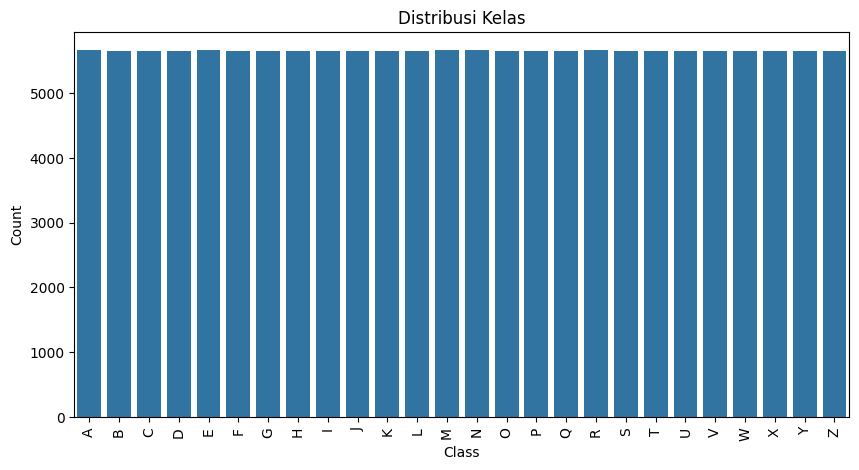

In [23]:
# Distribusi kelas di dataset
plot_class_distribution("/content/OCR_datasets/train_all")

### Normalisasi Data

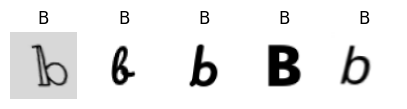

H/H_L_3418.png -> (64, 64)
H/aug_931_augmented_77.png -> (64, 64)
H/H_U_2073.png -> (64, 64)
H/aug_775_augmented_584.png -> (64, 64)
H/H_U_712.png -> (64, 64)


In [ ]:
# Menampilkan gambar dari folder train_all
show_random_images("OCR_datasets/train_all")
# Cek resolution size dari 5 gambar secara acak dari data train_all
check_image_resolution(merged_dir, num_samples=5)

In [25]:
# Direktori dataset
dataset_path = "/content/OCR_datasets"
train_dir = os.path.join(dataset_path, "train_all")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

# Buat objek ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Data generator untuk training
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=True
)

# Data generator untuk validation
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Data generator untuk test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=1,
    class_mode="categorical",
    shuffle=False
)

Found 146983 images belonging to 26 classes.
Found 26245 images belonging to 26 classes.
Found 26265 images belonging to 26 classes.


## Modelling

In [26]:
print(f"jumlah kelas :", len(train_generator.class_indices))
print(train_generator.class_indices)  # Mengecek jumlah kelas yang dikenali

jumlah kelas : 26
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [27]:
# Inisialisasi model Sequential
model = Sequential()

# Input Shape
model.add(tf.keras.layers.Input(shape=(64, 64, 1)))

# 1st Convolutional layer, Batch Normalization layer, dan Pooling layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, dan Pooling layer
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, dan Pooling layer
model.add(Conv2D(128, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(26, activation='softmax'))  # Output layer dengan 26 kelas

# Compile model
model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Print summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 26)                  │           1,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,302,170 (4.97 MB)

 Trainable params: 1,301,658 (4.97 MB)

 Non-trainable params: 512 (2.00 KB)

None


In [29]:
class CustomModelCheckpoint(Callback):
    def __init__(self, loss_tolerance):
        super(CustomModelCheckpoint, self).__init__()
        self.best_val_acc = 0
        self.best_val_loss = float("inf")
        self.loss_tolerance = loss_tolerance  # Toleransi kenaikan val_loss

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_acc = logs.get("val_accuracy", 0)
        val_loss = logs.get("val_loss", float("inf"))

        # Simpan model jika val_acc meningkat atau val_loss dalam batas toleransi
        if (val_acc > self.best_val_acc or
            (val_acc == self.best_val_acc and val_loss < self.best_val_loss + self.loss_tolerance)):
            self.best_val_acc = val_acc
            self.best_val_loss = val_loss
            self.model.save("best_model.keras")
            print(f"Model disimpan dengan val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}")

# Inisialisasi Callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
custom_checkpoint = CustomModelCheckpoint(loss_tolerance=0.050)

In [30]:
# Training model dengan callbacks
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[custom_checkpoint, reduce_lr, early_stopping])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4591/4594 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1477 - loss: 2.8214Model disimpan dengan val_acc: 0.6631, val_loss: 1.1981
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - accuracy: 0.1478 - loss: 2.8210 - val_accuracy: 0.6631 - val_loss: 1.1981 - learning_rate: 0.0010
Epoch 2/50
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6020 - loss: 1.2341Model disimpan dengan val_acc: 0.8578, val_loss: 0.5052
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 69s 14ms/step - accuracy: 0.6020 - loss: 1.2341 - val_accuracy: 0.8578 - val_loss: 0.5052 - learning_rate: 0.0010
Epoch 3/50
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 66s 14ms/step - accuracy: 0.7721 - loss: 0.7061 - val_accuracy: 0.8349 - val_loss: 0.7055 - learning_rate: 0.0010
Epoch 4/50
4593/4594 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8585 - loss: 0.4578Model disimpan dengan val_acc: 0.9308, val_loss: 0.2448
4594/4594 ━━━━━━━━━━━━━━━━━━━━ 66s 14ms/step - accuracy: 0.8585 - loss: 0.4577 - val_accuracy: 0.9308 - val_loss: 0.2448 - learning_r

## Evaluasi dan Visualisasi

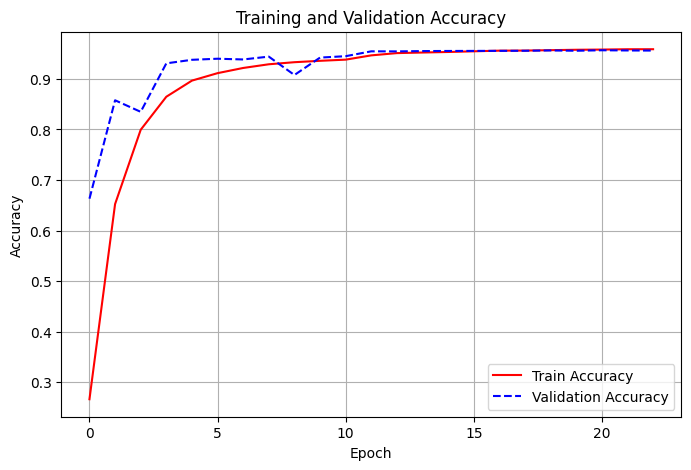

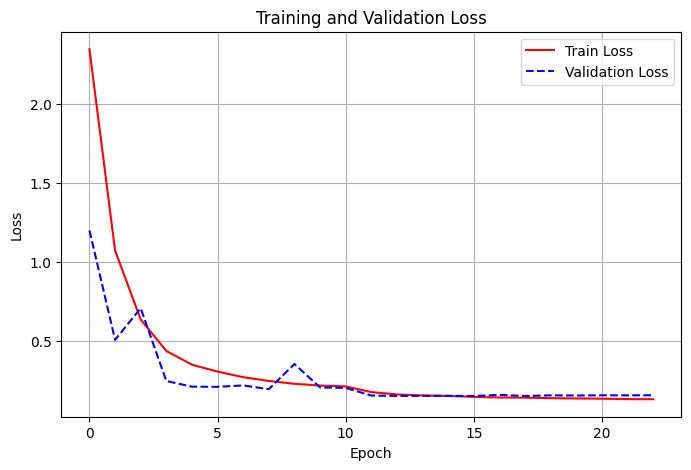

In [31]:
# Ambil data akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r-', label='Train Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
# Reset test generator
test_generator.reset()

# Prediksi menggunakan model
preds = model.predict(test_generator, verbose=0)

# Konversi probabilitas ke label kelas (ambil indeks kelas dengan nilai tertinggi)
preds = np.argmax(preds, axis=1)

# Ambil label sebenarnya
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())  # Label kelas

# Print Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true=true_labels, y_pred=preds, target_names=class_names, digits=2))


Classification Report:

              precision    recall  f1-score   support

           A       0.99      0.97      0.98      1011
           B       0.99      0.97      0.98      1010
           C       0.99      0.96      0.97      1010
           D       0.98      0.97      0.97      1010
           E       0.99      0.96      0.98      1011
           F       0.98      0.96      0.97      1010
           G       0.98      0.94      0.96      1010
           H       0.98      0.97      0.98      1010
           I       0.81      0.92      0.86      1010
           J       0.95      0.96      0.95      1010
           K       0.98      0.97      0.97      1010
           L       0.94      0.79      0.86      1010
           M       0.99      0.97      0.98      1011
           N       0.97      0.97      0.97      1011
           O       0.98      0.97      0.97      1010
           P       0.99      0.96      0.98      1010
           Q       0.99      0.95      0.97      1010
  

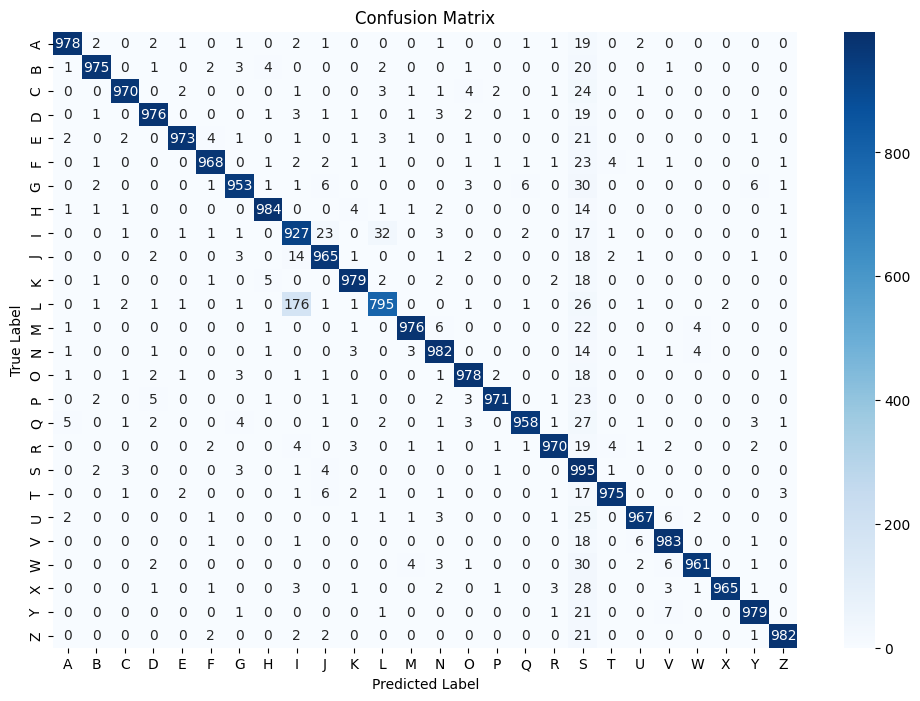

In [33]:
# Buat confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Visualisasi confusion matrix menggunakan seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices,
            yticklabels=test_generator.class_indices)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
# Evaluasi model pada dataset test
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Akurasi pada data test: {test_accuracy:.4f}")
print(f"Loss pada data test: {test_loss:.4f}")

26265/26265 ━━━━━━━━━━━━━━━━━━━━ 87s 3ms/step - accuracy: 0.9569 - loss: 0.1520
Akurasi pada data test: 0.9551
Loss pada data test: 0.1545


## Konversi Model

In [35]:
# Load model
model = tf.keras.models.load_model('/content/best_model.keras')

# Konversi ke Saved_Model
model.export('/content/saved_model/1')

Saved artifact at '/content/saved_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  138770490871632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490874128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490869328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490869136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490870672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490870480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490876432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490876816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490874512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138770490875472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1387704908

In [36]:
!pip install tensorflow==2.18.0 tensorflowjs -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 92.0 MB/s eta 0:00:00


In [37]:
# Konversi Saved_Model ke TensorFlow.js
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/1 \
    /content/modeltfjs

print("Model berhasil dikonversi ke TensorFlow.js.")

2025-03-27 21:25:45.877838: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743110745.913988   11223 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743110745.926106   11223 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-03-27 21:25:58.695862: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1743110758.696097   11223 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [38]:
# Konversi Saved_Model ke format TFLite
save_path = '/content/saved_model/1'
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()
with tf.io.gfile.GFile('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite dan disimpan sebagai model.tflite")

Model berhasil dikonversi ke TFLite dan disimpan sebagai model.tflite


In [39]:
labels = list(train_generator.class_indices.keys())
with open('labels.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

## Inference (Optional)

### Inference dengan Saved_Model

In [40]:
def images_preprocessing(filename):
    """Membaca, resize, dan memproses gambar grayscale sebelum inference."""
    # Membaca gambar dalam grayscale
    image = tf.io.decode_image(open(filename, 'rb').read(), channels=1)
    # Resize gambar ke ukuran yang sesuai dengan model (64x64)
    image = tf.image.resize(image, [64, 64])
    # Normalisasi gambar (skala nilai piksel dari 0-255 ke 0-1)
    image = image / 255.0
    # Tambahkan dimensi batch
    image_tensor = tf.expand_dims(image, 0)
    return image_tensor

# Memuat label dari file labels.txt
labels = []
with open('labels.txt', 'r') as f:
    labels = [line.strip() for line in f.readlines()]

Shape input image: (1, 64, 64, 1)
Predicted class: 16


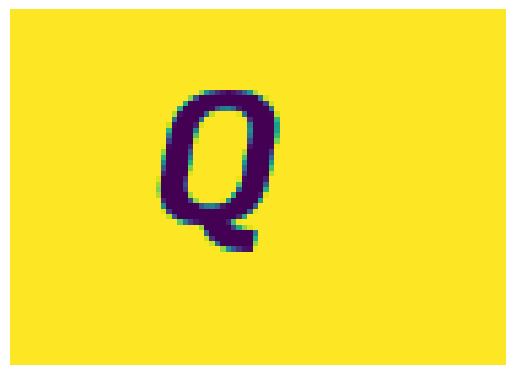

Prediksi:  Q


In [52]:
# Memuat model SavedModel yang sudah disimpan
model = tf.saved_model.load("/content/saved_model/1")

# Mendapatkan fungsi signature untuk inference
infer = model.signatures["serving_default"]

# Path ke gambar yang ingin diuji
unseen_image_dir = "/content/unseen_images"
image_files = os.listdir(unseen_image_dir)  # Mendapatkan list file

# Memilih file acak atau memberikan pesan jika folder kosong
selected_image = random.choice(image_files)

# Jika file terpilih, lanjutkan inference
if selected_image:
    image_path = os.path.join(unseen_image_dir, selected_image)

    # Preprocessing gambar
    input_image = images_preprocessing(image_path)
    print("Shape input image:", input_image.shape)

    # Lakukan inferensi
    predictions = infer(tf.constant(input_image))

    # Mendapatkan kelas dengan probabilitas tertinggi
    predicted_class = tf.argmax(predictions['output_0'][0]).numpy()
    print(f'Predicted class: {predicted_class}')

    # Buka gambar
    img = Image.open(image_path)

    # Tampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Print prediksi huruf
    print("Prediksi: ", labels[predicted_class])

### Inference dengan tflite

Shape input image: (1, 64, 64, 1)
Predicted class: 5


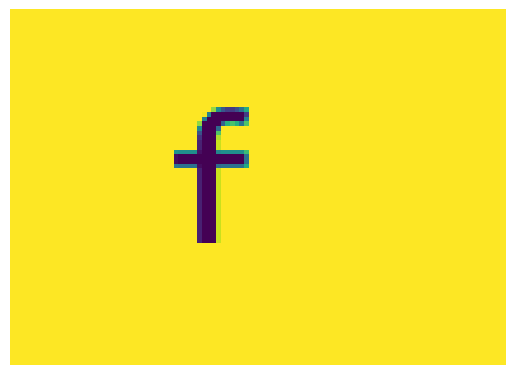

Prediksi:  F


In [55]:
# Memuat model TFLite
tflite_model_path = '/content/model.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Mendapatkan detail input dan output dari model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Path ke gambar yang ingin diuji
unseen_image_dir = "/content/unseen_images"
image_files = os.listdir(unseen_image_dir)

# Memilih file acak untuk inference
selected_image = random.choice(image_files)

# Jika file terpilih, lanjutkan inference
if selected_image:
    image_path = os.path.join(unseen_image_dir, selected_image)

    # Preprocessing gambar
    input_image = images_preprocessing(image_path).numpy()  # Konversi ke numpy array
    print("Shape input image:", input_image.shape)

    # Menyiapkan input untuk model
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Menjalankan inferensi
    interpreter.invoke()

    # Mendapatkan hasil output
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Mendapatkan kelas dengan probabilitas tertinggi
    predicted_class = np.argmax(output_data[0])

    print(f'Predicted class: {predicted_class}')

    # Buka gambar
    img = Image.open(image_path)

    # Tampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Print prediksi huruf
    print("Prediksi: ", labels[predicted_class])

In [43]:
!pip freeze > requirements.txt